In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd


path2figdir = "figs/Hair/20"
sc.settings.figdir =path2figdir
sc.set_figure_params(vector_friendly=True)

# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
### test whole data with RNA only 
path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
# model = HALOVI(
#     adata_mvi,
#     n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
#     n_regions=(adata_mvi.var['modality']=='Peaks').sum()
# )

model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)    

n_genes :959
fine tune is False
gate decoder initialization n_input 20, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [8]:
## load pre-trained models
# model = model.load("model_hair_causal01", adata_mvi)
# model = model.load("model_hair_nocausal", adata_mvi)
model = model.load("model_hair_nocausal_20",adata_mvi)

INFO     File model_hair_nocausal_20/model.pt already downloaded                             
n_genes :959
fine tune is False
gate decoder initialization n_input 20, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=800, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 800/800: 100%|██████████| 800/800 [53:01<00:00,  3.98s/it, loss=8.97e+04, v_num=1]


In [5]:
# model.save("model_myeloid_data_nocausal",overwrite=True)
model.save("model_hair_nocausal_20",overwrite=True)

In [5]:
## load causal model
model = model.load("model_hair_causal01_20",adata_mvi)

INFO     File model_hair_causal01_20/model.pt already downloaded                             
n_genes :959
fine tune is False
gate decoder initialization n_input 20, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
model.module.alpha = 0.1
model.module.beta_2 = 1e6
model.module.beta_3 = 1e6
model.module.beta_1 = 1e6
model.module.n_latent_dep = 10

print(model.module.alpha)
# model.module.n_latent_dep = 15



### for latent=10

# model.module.beta_2 = 1e7
# model.module.beta_3 = 1e8
# model.module.beta_1 = 1e7

0.1


In [5]:
## finetune without L0
# model.module.alpha = 0.06
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=800, batch_size=600)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/800:   0%|          | 0/800 [00:00<?, ?it/s]reconst_loss 1.21E+05, nod_loss 1.01E+05
reconst_loss 1.09E+05, nod_loss 9.89E+04
reconst_loss 1.08E+05, nod_loss 1.04E+05
reconst_loss 1.09E+05, nod_loss 1.05E+05
reconst_loss 1.08E+05, nod_loss 9.31E+04
reconst_loss 1.07E+05, nod_loss 1.02E+05
reconst_loss 1.09E+05, nod_loss 9.74E+04
reconst_loss 1.01E+05, nod_loss 9.22E+04
reconst_loss 1.03E+05, nod_loss 9.93E+04
reconst_loss 1.04E+05, nod_loss 9.74E+04
Epoch 2/800:   0%|          | 1/800 [00:05<1:19:05,  5.94s/it, loss=2.07e+05, v_num=1]reconst_loss 1.03E+05, nod_loss 9.38E+04
reconst_loss 1.02E+05, nod_loss 1.07E+05
reconst_loss 1.06E+05, nod_loss 1.02E+05
reconst_loss 1.06E+05, nod_loss 1.03E+05
reconst_loss 1.04E+05, nod_loss 8.72E+04
reconst_loss 1.00E+05, nod_loss 1.04E+05
reconst_loss 9.82E+04, nod_loss 1.01E+05
reconst_loss 1.02E+05, nod_loss 9.93E+04
reconst_loss 1.02E+05, nod_loss 9.14E+04
reconst_loss 9.97E+04, nod_loss 9.66E+04
Epoch 3/800:   0%|          | 2/800 [00:11

In [9]:
# model.save("model_hair_causal01",overwrite=True)
# model.save("model_hair_causal01_20",overwrite=True)
model.save("model_hair_causal006_20",overwrite=True)

In [4]:
model = model.load("model_hair_causal01", adata_mvi)

INFO     File model_hair_causal01/model.pt already downloaded                                
n_genes :959
fine tune is False
gate decoder initialization n_input 10, n_output 112656,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [6]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)


In [11]:
latent_expr_indep.shape

(6436, 5)

In [11]:
model.module.n_latent_dep

15

In [7]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir




latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score3 = []
score4=[]

cells = latent_expr.shape[0]
locals = 2000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:,:], latent_expr_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:,:], latent_atac_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:(i+1)*locals,:], latent_expr_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:(i+1)*locals,:], latent_atac_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())

score3 = np.mean(np.array(score3))
score4 = np.mean(np.array(score4))
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

score3 0.0665466403741055 and score4 0.06655504689807458


-8.406523969078927e-06

In [8]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
# times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score1 = []
score2=[]

cells = latent_expr.shape[0]
locals = 2000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:,:], latent_expr_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:,:], latent_atac_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:(i+1)*locals,:], latent_expr_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:(i+1)*locals,:], latent_atac_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())


score1 = np.mean(np.array(score1))
score2 = np.mean(np.array(score2))

print("score1 {} and score2 {}".format(score1, score2))


score1 0.06655149236737236 and score2 0.06655155671555196


In [12]:
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)


## nocausal results

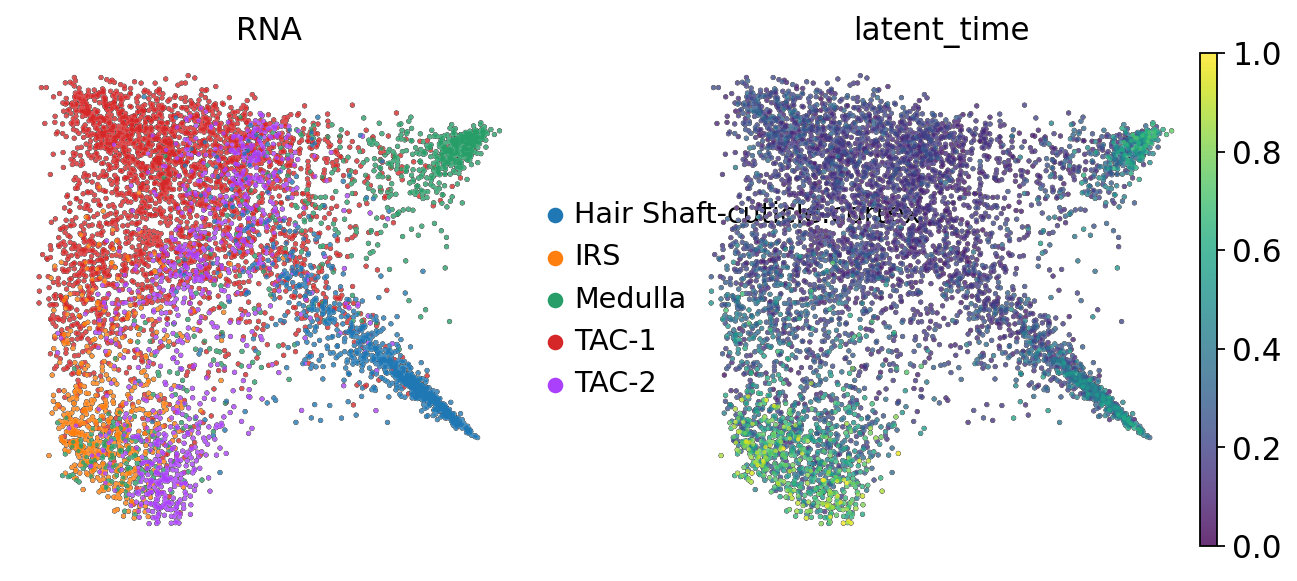

In [8]:

adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
# sc.pp.neighbors(adata_mvi, use_rep = 'latent')

# sc.tl.umap(adata_mvi, min_dist=0.1)

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['celltype', 'latent_time'])


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.2)



sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', "latent_time"], title="RNA")


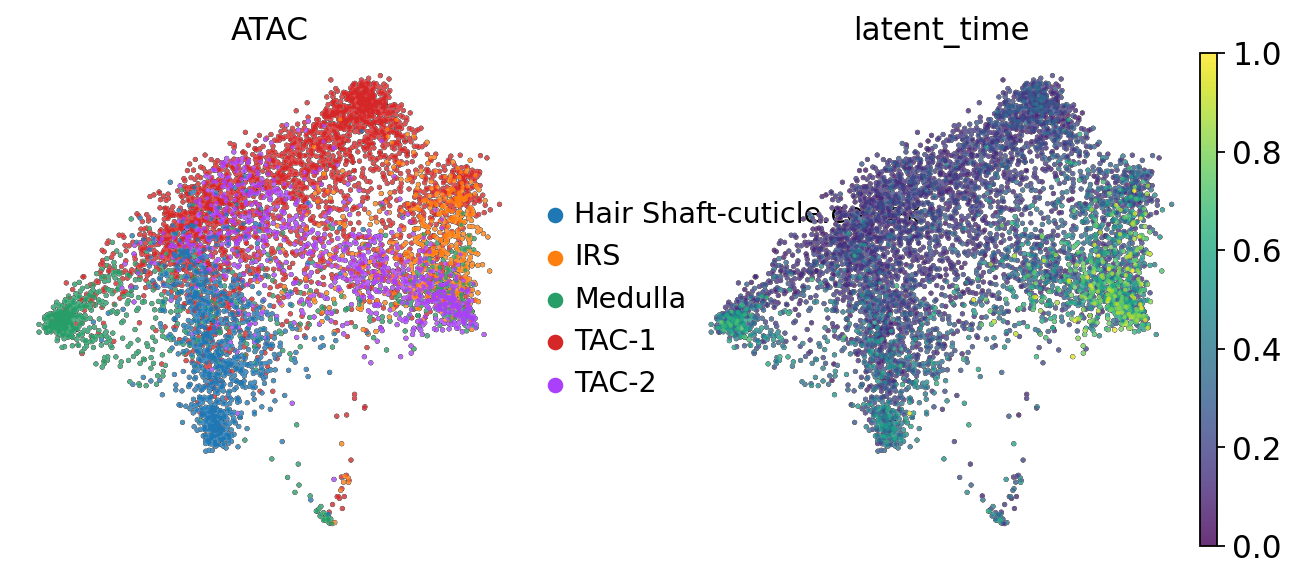

In [9]:
adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
# sc.pp.neighbors(adata_mvi, use_rep = 'latent')

# sc.tl.umap(adata_mvi, min_dist=0.1)

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['celltype', 'latent_time'])


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.2)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', "latent_time"], title="ATAC")          

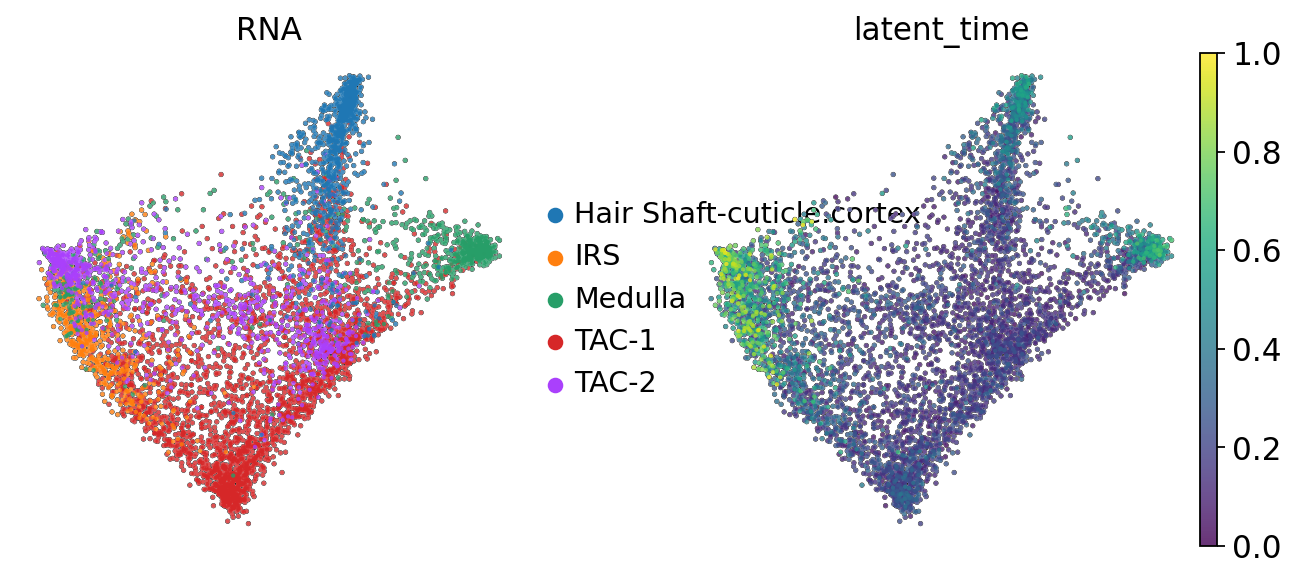

In [12]:
adata_mvi.obsm["latent"] = np.concatenate((latent_expr,latent_acc),axis=1)

# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
# sc.pp.neighbors(adata_mvi, use_rep = 'latent')

# sc.tl.umap(adata_mvi, min_dist=0.1)

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['celltype', 'latent_time'])


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.2)



sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', "latent_time"], title="RNA")


## Causal representations


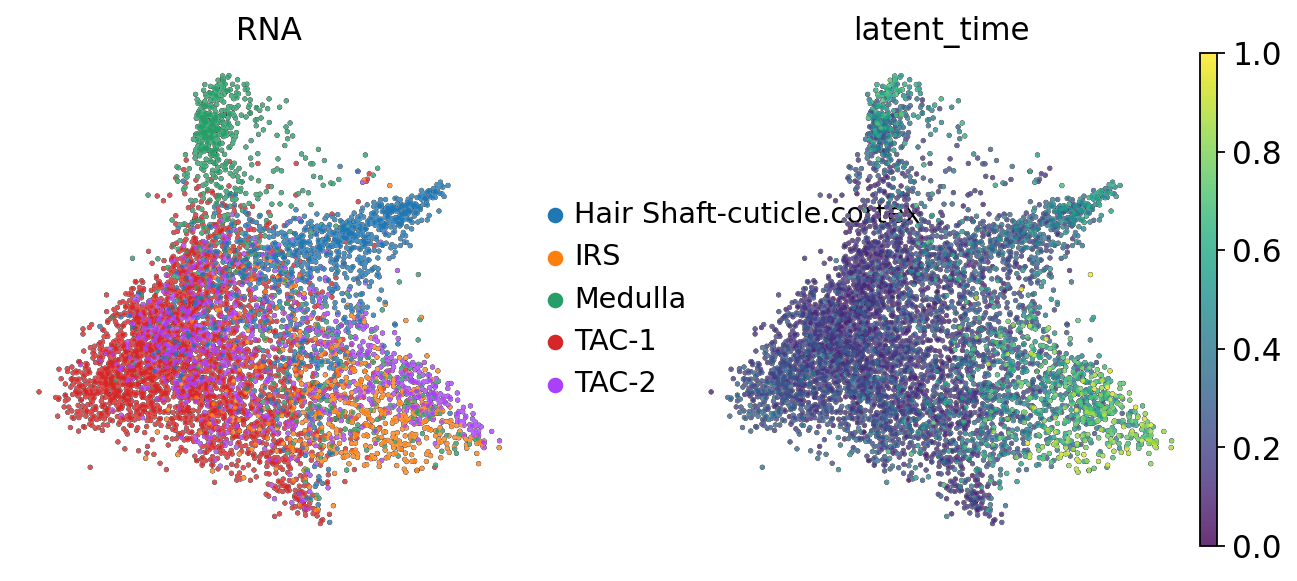

In [9]:
adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)


sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype', 'latent_time'], title="RNA")

In [38]:
gene_name = adata_mvi.var[adata_mvi.var.modality=="Gene Expression"]

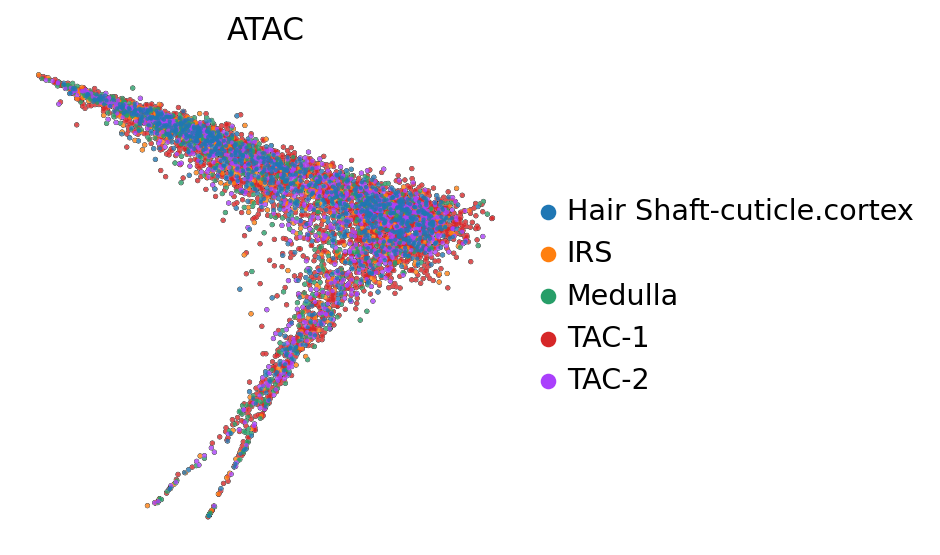

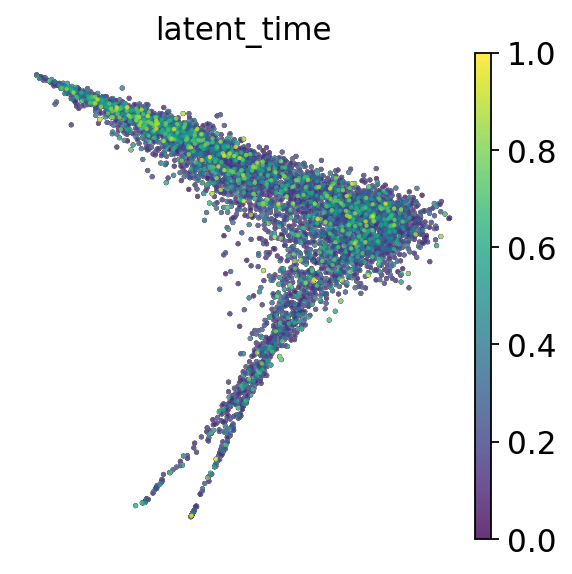

In [10]:
save_path = "_ATAC.pdf"
save_path2 = "_ATAC_latent.pdf"

adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15)
# sc.tl.umap(adata_mvi, min_dist=0.1)


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)


sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['celltype'], title="ATAC")

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['latent_time'], title="latent_time")


# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['celltype'], title="ATAC", save=save_path)

# sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=['latent_time'], title="latent_time", save=save_path2)


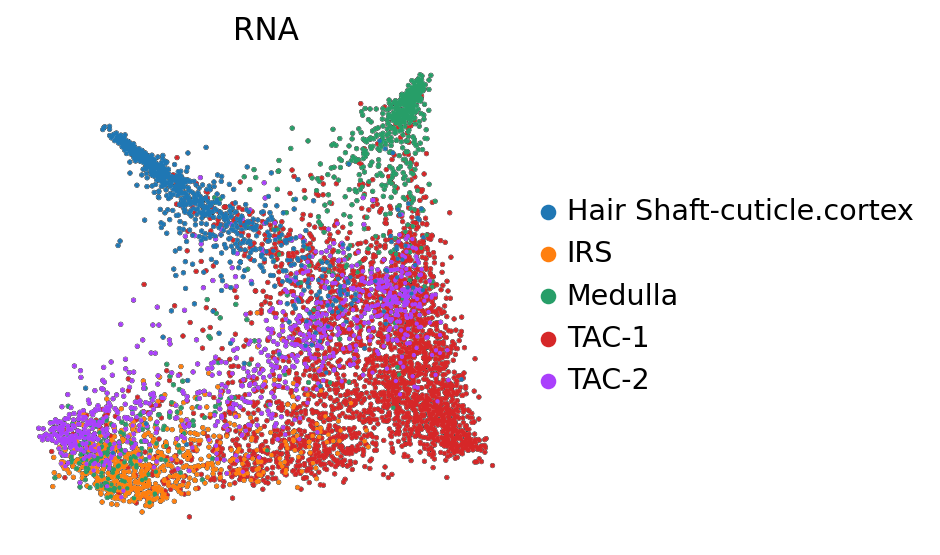

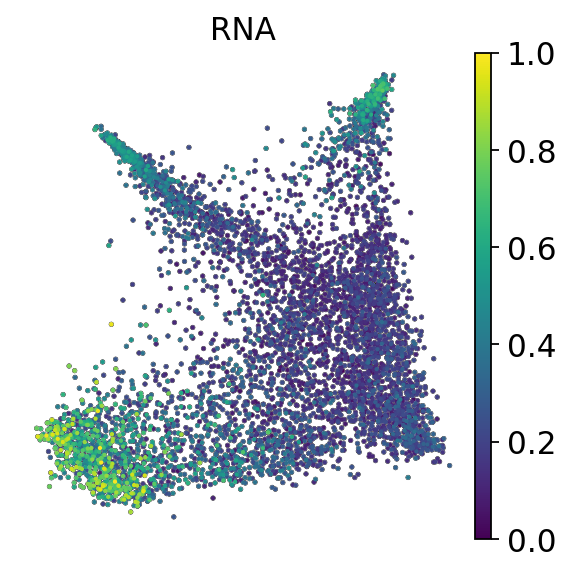

In [15]:
# adata_mvi.obsm["latent"] = np.concatenate((latent_atac_dep, latent_expr), axis=1)
save_path = "_RNA.pdf"
save_path2 = "_RNA_latent.pdf"

adata_mvi.obsm["latent"] = latent_expr

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

# sc.pl.umap(rna_data, frameon=False, size = 10, alpha = 1, add_outline=True,
#           outline_width=(0.1,0), color='leiden')


sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['celltype'], title="RNA", save=save_path)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['latent_time'],title="RNA",save=save_path2)          

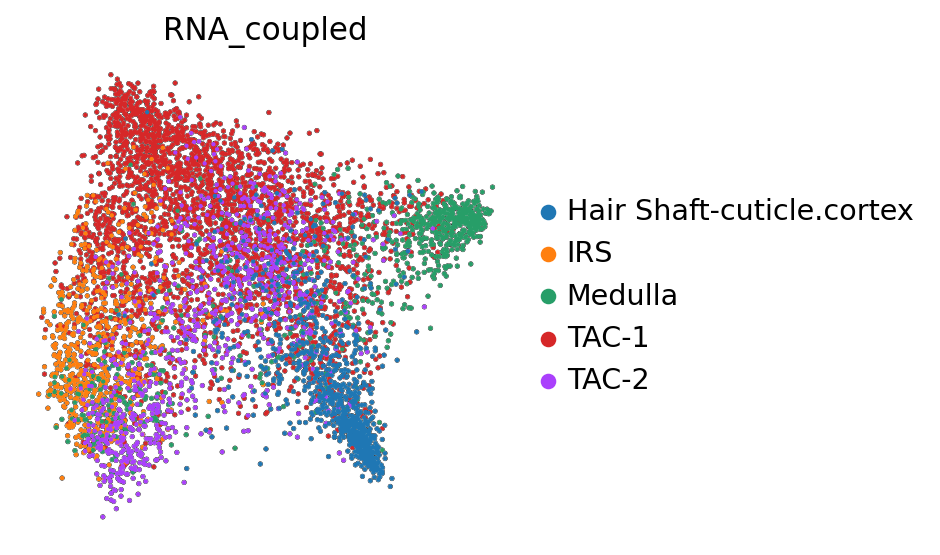

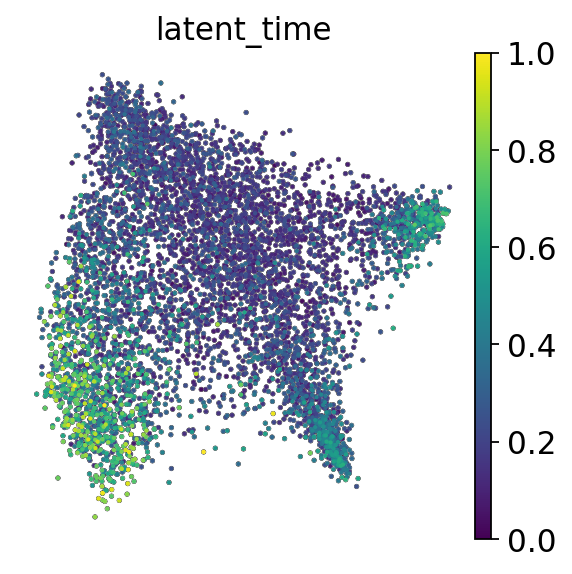

In [16]:
save_path = "_RNA_coupled.pdf"
save_path2 = "_RNA_coupled_latent.pdf"


adata_mvi.obsm["latent"] =latent_expr_dep
# sc.pp.neighbors(adata_mvi, use_rep="latent")



# sc.tl.umap(adata_mvi,min_dist =0.5)

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
# sc.tl.umap(adata_mvi, min_dist=0.1)

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

%matplotlib inline
# sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=15, alpha = 1, frameon=False, ncols=2,outline_width=(0.1,0), title="RNA coupled")
sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['celltype'], title="RNA_coupled", save=save_path)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['latent_time'], title="latent_time", save=save_path2)    

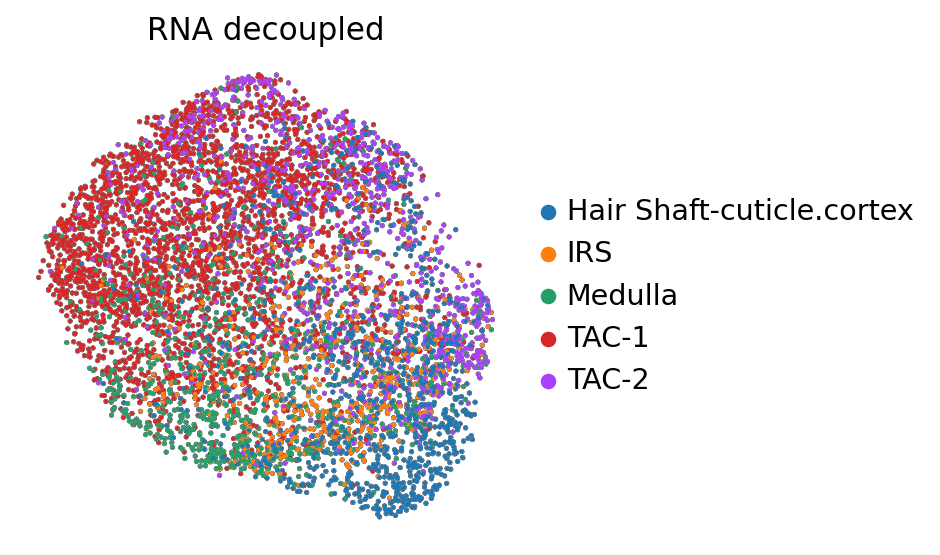

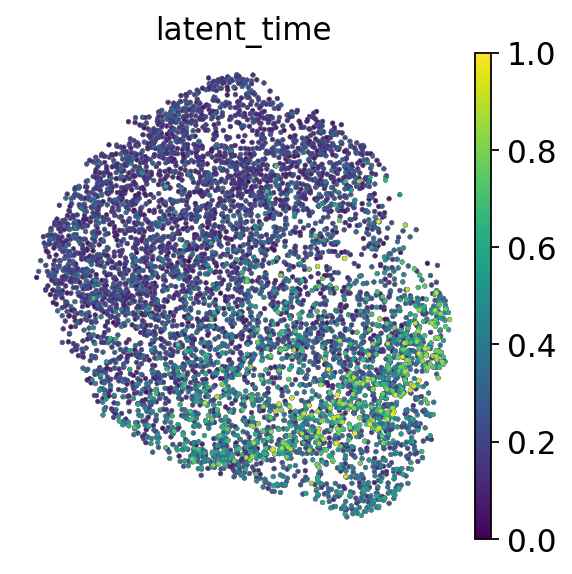

In [17]:

save_path = "_RNA_decoupled.pdf"
save_path2 = "_RNA_decoupled_latent.pdf"


adata_mvi.obsm["latent"] =latent_expr_indep
# sc.pp.neighbors(adata_mvi, use_rep="latent")
# sc.tl.umap(adata_mvi,min_dist =0.1)


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

%matplotlib inline
# sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=15, alpha =1 ,frameon=False, ncols=2, outline_width=(0.1,0), title="RNA decoupled")

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['celltype'], title="RNA decoupled", save=save_path)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['latent_time'], title="latent_time",save=save_path2)   

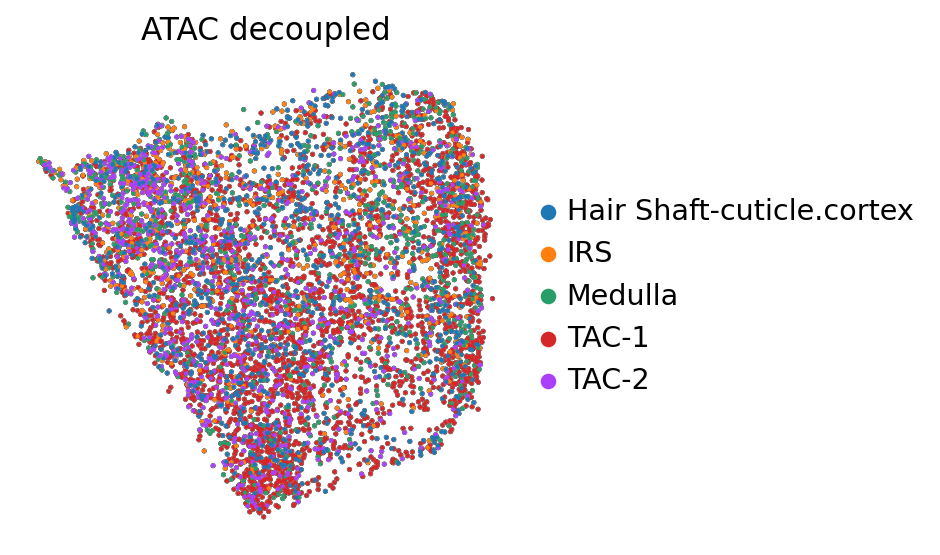

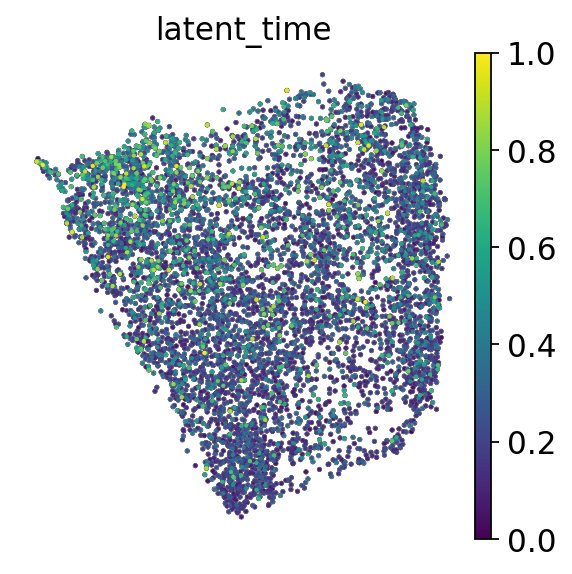

In [18]:

save_path = "_ATAC_decoupled.pdf"
save_path2 = "_ATAC_decoupled_latent.pdf"


adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

# sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=20, frameon=False, ncols=2,outline_width=(0.1,0), title="ATAC decouple", alpha = 1)
sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['celltype'], title="ATAC decoupled", save=save_path)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['latent_time'], title="latent_time", save=save_path2) 

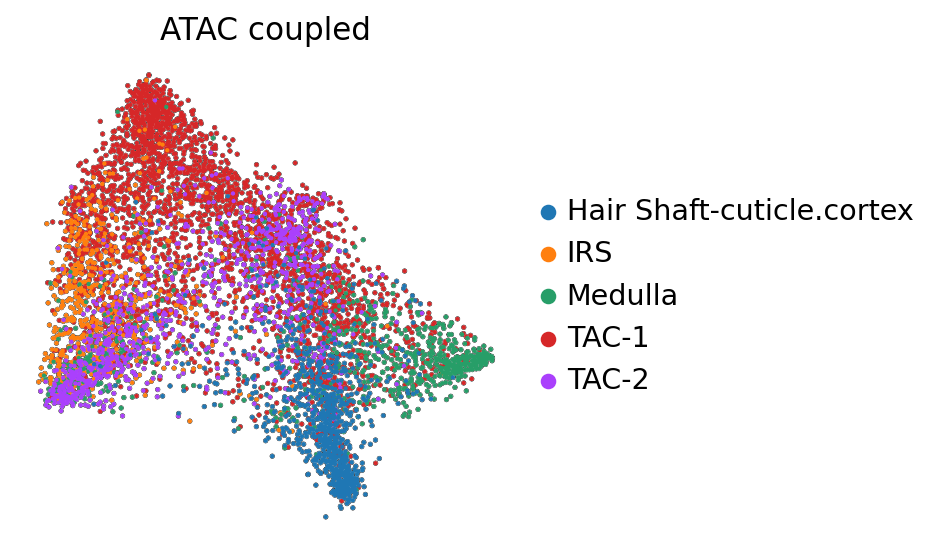

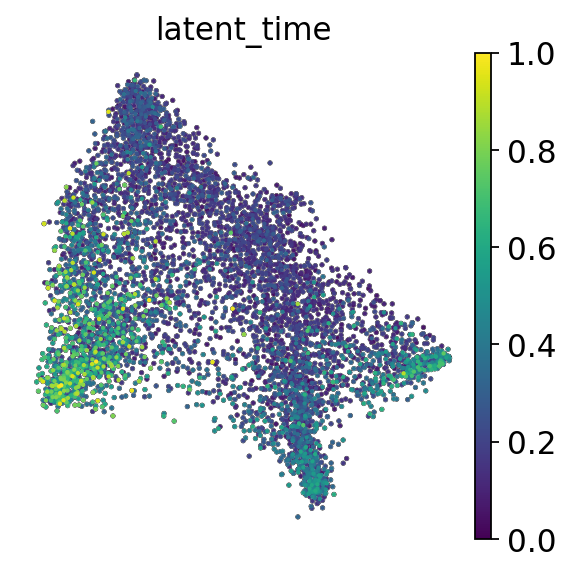

In [19]:


save_path = "_ATAC_coupled.pdf"
save_path2 = "_ATAC_coupled_latent.pdf"

adata_mvi.obsm["latent"] =latent_atac_dep

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

# sc.pl.umap(adata_mvi,color=['celltype', "latent_time"], s=20, frameon=False, ncols=2, outline_width=(0.1, 0), title="ATAC coupled", alpha = 0.8)
sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['celltype'], title="ATAC coupled",save=save_path)

sc.pl.umap(adata_mvi, frameon=False, size = 15, alpha = 1, add_outline=True,
          outline_width=(0.1,0), color=['latent_time'], title="latent_time",save=save_path2) 
